# Tractor Sales
This data shows the details of the no of the tractors sold on the monthly basis for the year 2020.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

#### 1. Import the data from `TractorSales.csv`.

In [2]:
# Loading the Data
df = pd.read_csv('TractorSales.csv', sep=',')
df.head()

,Month-Year,Number of Tractor Sold
0,3-Jan,141
1,3-Feb,157
2,3-Mar,185
3,3-Apr,199
4,3-May,203


#### 2. Convert Month-Year to a datetime. Use the function pd.date_range. The series starts at 2003-01-01.

In [3]:
df['date'] = pd.date_range(start='2003-01-01', freq='MS', periods=len(df))
df['sold'] = df.iloc[:,1]
df1 = df.loc[:, ['date', 'sold']].copy()
df1

,date,sold
0,2003-01-01,141
1,2003-02-01,157
2,2003-03-01,185
3,2003-04-01,199
4,2003-05-01,203
...,...,...
139,2014-08-01,848
140,2014-09-01,640
141,2014-10-01,581
142,2014-11-01,519


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    144 non-null    datetime64[ns]
 1   sold    144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


#### 3. Visualize the Data.
* Plot the time series data to visualize the trend and any cyclic patterns.

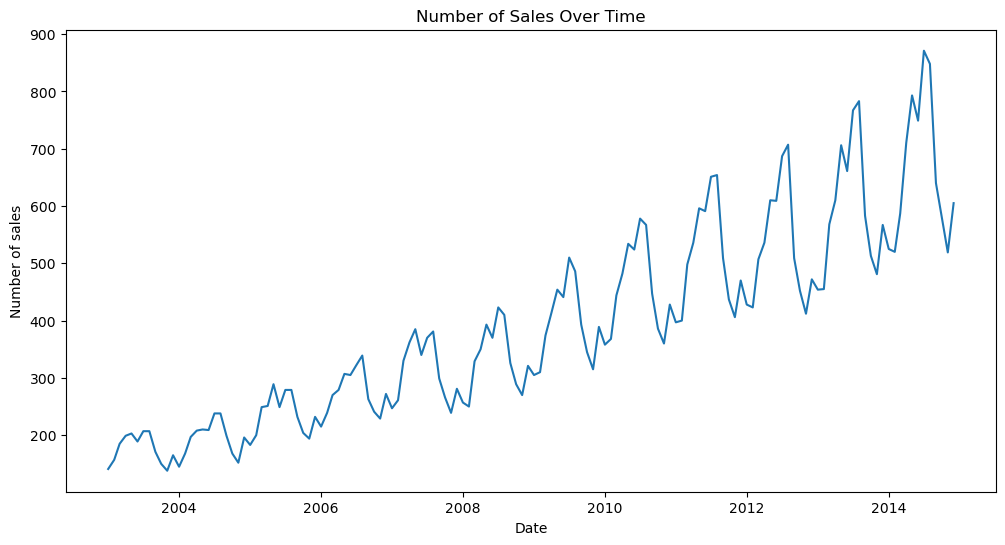

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df1, x='date', y='sold')
plt.title('Number of Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Number of sales')
plt.show()

#### 4. Decompose the Time Series into its components: trend, seasonality, and residuals.

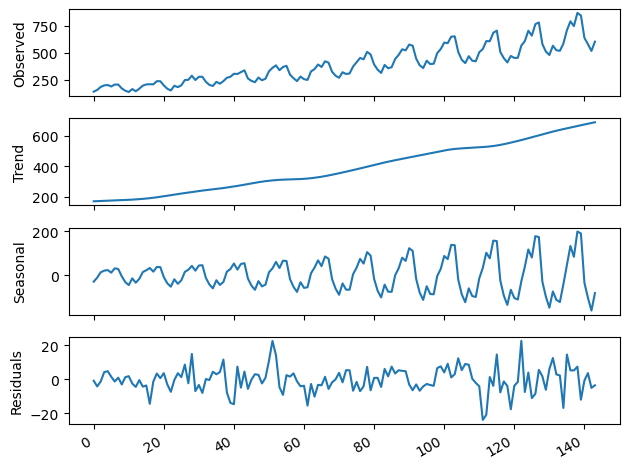

In [6]:
advanced_decomposition = STL(df1.sold, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()


#### 5. Apply appropriate transformations to get a stationary time series.
* Visualize the resulting time series.
* Decompose the resulting time series.
* Test if the resulting time series is stationary.

In [7]:
# logarithmize sold to stabilize the variance
df1['log_sold'] = np.log(df1['sold'])
df1.head()

,date,sold,log_sold
0,2003-01-01,141,4.948760
1,2003-02-01,157,5.056246
2,2003-03-01,185,5.220356
3,2003-04-01,199,5.293305
4,2003-05-01,203,5.313206


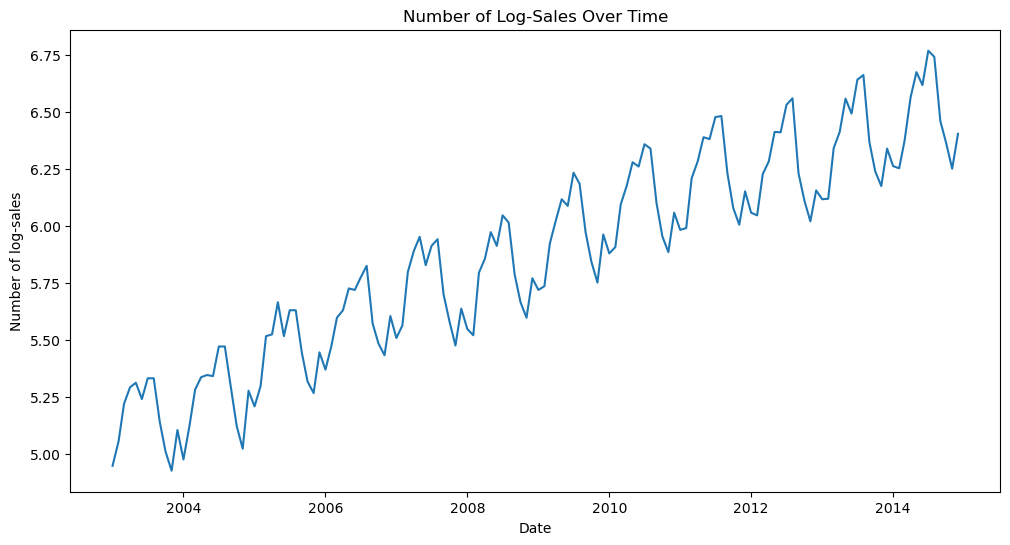

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df1, x='date', y='log_sold')
plt.title('Number of Log-Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Number of log-sales')
plt.show()

In [9]:
# Differencing to eliminate trend and seasonality
df1['log_sold_diff'] = df1.log_sold.diff().diff(periods=12)
df1

,date,sold,log_sold,log_sold_diff
0,2003-01-01,141,4.948760,NaN
1,2003-02-01,157,5.056246,NaN
2,2003-03-01,185,5.220356,NaN
3,2003-04-01,199,5.293305,NaN
4,2003-05-01,203,5.313206,NaN
...,...,...,...,...
139,2014-08-01,848,6.742881,-0.047407
140,2014-09-01,640,6.461468,0.013533
141,2014-10-01,581,6.364751,0.031194
142,2014-11-01,519,6.251904,-0.048438


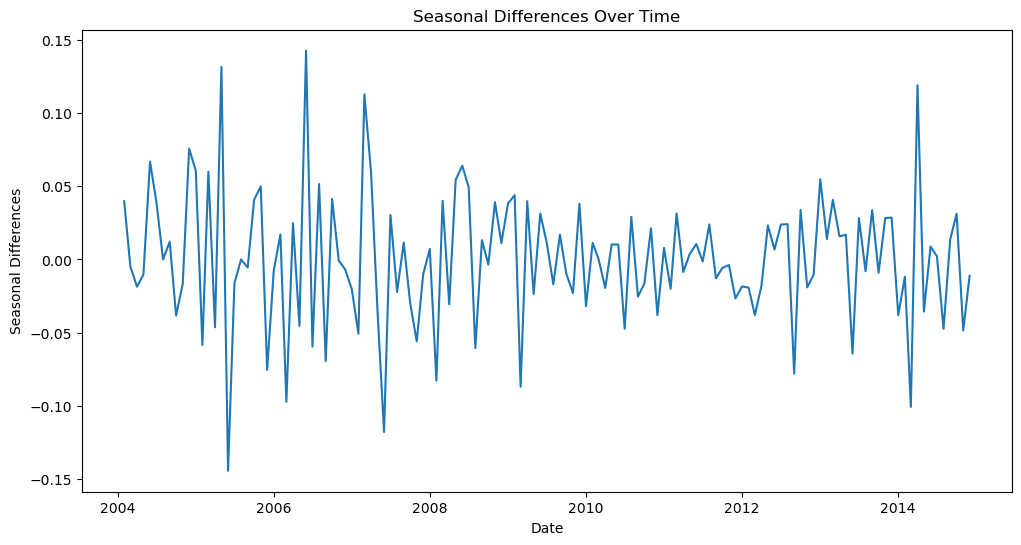

In [10]:
# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df1, x='date', y='log_sold_diff')
plt.title('Seasonal Differences Over Time')
plt.xlabel('Date')
plt.ylabel('Seasonal Differences')
plt.show()

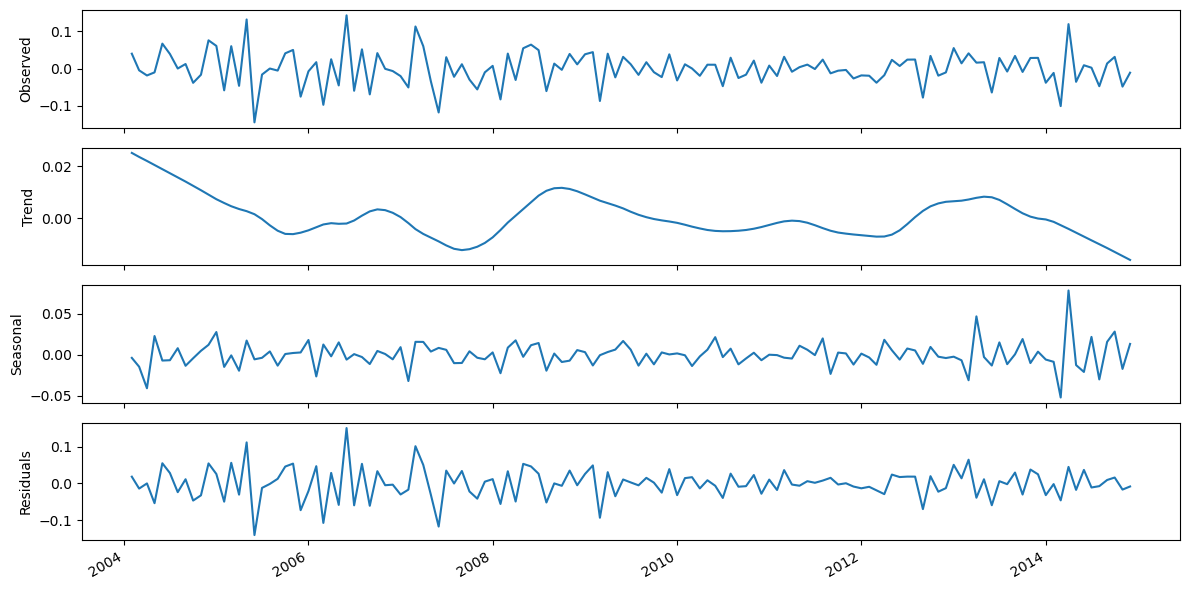

In [11]:
advanced_decomposition = STL(df1.set_index('date').log_sold_diff.dropna(), period=12).fit()
plt.rcdefaults()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12, 6))

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [12]:
# ADF Test for stationarity
adf_test = adfuller(df1.set_index('date').log_sold_diff.dropna())
print(f'p-value: {adf_test[1]}')

p-value: 0.0002128161041120055


p-value < 0.05: We reject the null hypothesis and conclude that the transformed time series is stationary.

#### 6. Compare the autocorrelation functions of the orgininal series with the transformed series.

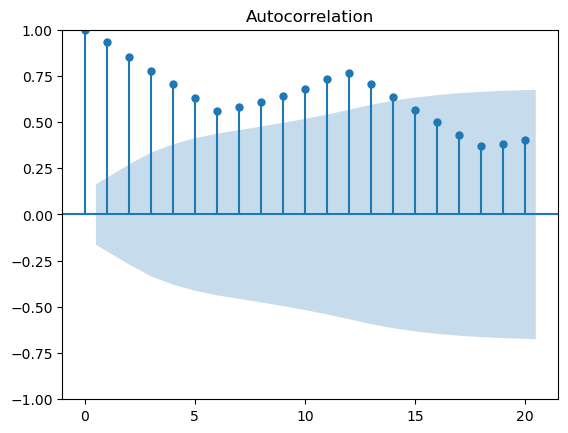

In [13]:
# ACF Plot of orgininal series
plot_acf(df1.set_index('date').sold, lags=20)
plt.show()

The autocorrelations of the first 14 lags differ significantly from zero.

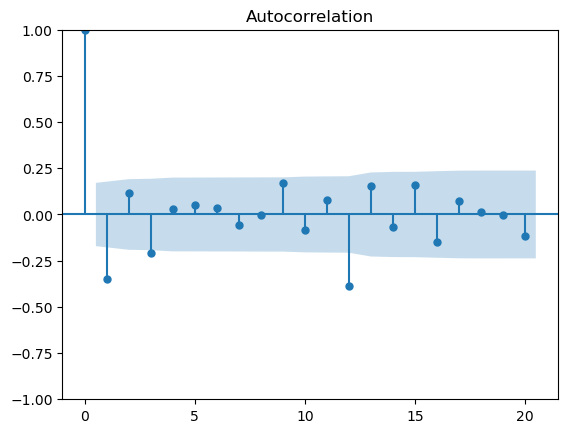

In [14]:
# ACF Plot of transformed series
plot_acf(df1.set_index('date').log_sold_diff.dropna(), lags=20)
plt.show()

Only the autocorrelations of lag 1, 3 and 12 of the transformed series differ significantly from zero.  
This means that only these values may be helpful in predicting the current value.